In [2]:
from elasticsearch import Elasticsearch
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import re
import math
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch

# 데이터 가져오기

In [2]:
df = pd.read_json('../../data/wikipedia_documents.json').T

In [3]:
df.head()

,text,corpus_source,url,domain,title,author,html,document_id
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2
3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4


In [4]:
df = df.drop_duplicates(subset=['text'])
df.nunique()

text             56737
corpus_source        1
url                  1
domain               0
title            31726
author               0
html                 0
document_id      56737
dtype: int64

In [5]:
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

In [6]:
def tokenized_len(row):
  return len(tokenizer.tokenize(row))

In [7]:
df['tokenizedCount'] = df['text'].apply(tokenized_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (1131 > 512). Running this sequence through the model will result in indexing errors


<AxesSubplot:xlabel='tokenizedCount', ylabel='Count'>

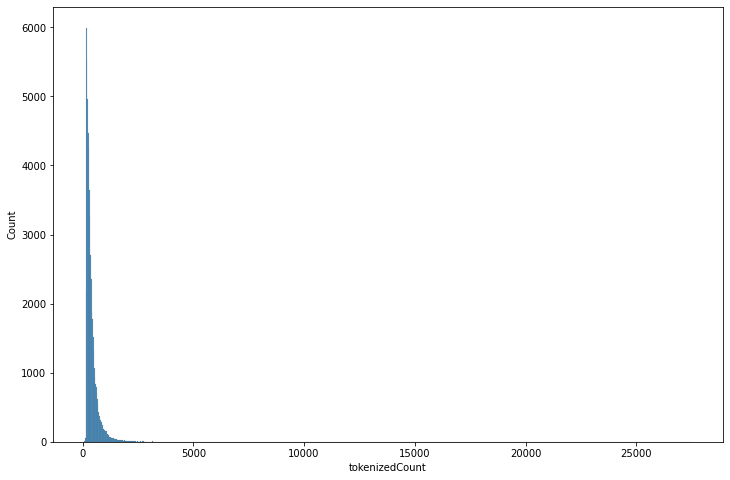

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(x='tokenizedCount', data=df, bins=1000)

In [9]:
df['tokenizedCount'].describe()

count    56737.000000
mean       401.889208
std        392.152975
min         54.000000
25%        221.000000
50%        308.000000
75%        457.000000
max      27539.000000
Name: tokenizedCount, dtype: float64

In [ ]:
df['text'][60]

In [11]:
len(tokenizer.tokenize(df['text'][60]))

440

In [12]:
end_of_sentences = re.findall(r'[가-힣]+\S*\.', df['text'][60])

In [13]:
sentences = re.split(r'[가-힣]+\S\.', df['text'][60])

In [14]:
print(end_of_sentences, len(end_of_sentences))
print(sentences, len(sentences))

['연결되었습니다.', '마감...'] 2
['KETEL의 초기화면\n\n\n\u3000CONNECT 240\n\u3000[[[[[[[\n\u3000### ketel에 ', '(korea:pc\n\u3000### Welcome to ketel!!\n\u3000### 서비스 명에 ketel을 입력하십시오\n\u3000### Please type "ke" for KETEL English Service\n\u3000서비스 명(login):kete\n\n\n\u3000\u3000\u3000\u3000\u3000\u3000\u3000KK\u3000 KKK\u3000\u3000EEEEE\u3000TTTTTTTT\u3000\u3000EEEEEE\u3000 Lt\n\u3000\u3000\u3000\u3000\u3000\u3000 KK\u3000KK\u3000\u3000\u3000EE\u3000\u3000\u3000\u3000 \u3000TT\u3000\u3000\u3000 EE\u3000\u3000\u3000\u3000\n\u3000\u3000\u3000\u3000\u3000\u3000KKK\u3000\u3000\u3000\u3000 EEEE\u3000\u3000\u3000\u3000TT\u3000\u3000\u3000EEEE\u3000\u3000 L\n\u3000\u3000\u3000\u3000\u3000 KK KK\u3000\u3000\u3000 EE\u3000\u3000\u3000\u3000\u3000TT\u3000\u3000\u3000EE\u3000\u3000\u3000\u3000L\n\u3000\u3000\u3000\u3000\u3000KK\u3000 KKK\u3000EEEEEE\u3000\u3000 TT\u3000\u3000\u3000EEEEEE\u3000 LLLLLLL\n\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000 <<<알립니다>>\n\u30001.<<KETEL 정보서비스 일시

# 데이터 쪼개기

In [15]:
splited_documents = []

In [16]:
count = 0
for index, document in tqdm(df.iterrows()):
  # print("==================count=====================",count)
  
  original_passage = document['text']

  length_of_tokenized_text = len(tokenizer.tokenize(original_passage))

  number_of_passages_to_create = math.ceil(length_of_tokenized_text / 400)  # 510으로 안하는 이유는 110만큼의 buffer를 주기 위해서
  min_required_length = length_of_tokenized_text // number_of_passages_to_create  # 최소 길이
  max_possible_length = min_required_length + 110  # 최대길이

  end_of_sentences = re.findall(r'[가-힣]+\S*\.', original_passage)
  sentences = re.split(r'[가-힣]+\S*\.', original_passage)
  sentence_counter = 0


  # print(min_required_length)
  for i in range(number_of_passages_to_create):
    partial_text = ''
    partial_text_length = 0

    if sentence_counter == len(end_of_sentences)-1:
      break
    
    for j in range(len(sentences) - 1):
      partial_text += sentences[sentence_counter] + end_of_sentences[sentence_counter]
      partial_text_length += len(tokenizer.tokenize(sentences[sentence_counter] + end_of_sentences[sentence_counter]))
      # print('==============================', sentence_counter, len(sentences)-1, len(end_of_sentences)-1)
      # print(partial_text, partial_text_length)
      sentence_counter += 1
      if partial_text_length >= min_required_length or sentence_counter == len(end_of_sentences)-1:
        
        if sentence_counter == len(end_of_sentences)-1:
          partial_text += sentences[-1]
        document_to_be_added = {
          'text': partial_text,
          'title': document['title'],
          'document_id': count # document['document_id']
        }

        splited_documents.append(document_to_be_added)
        count +=1
        break
  

56737it [03:18, 285.32it/s]


In [17]:
len(splited_documents)

78411

In [18]:
splited_documents[7504]

{'text': '빌렌도르프의 비너스(Venus von Willendorf)는 1908년 오스트리아 니더외스터라이히주 빌렌도르프 근교의 구석기 시대 지층에서 고고학자 요제프 촘바티가 발견한 11.1 cm 키의 여자 조각상이다. 그 지역에서 나지 않는 어란상 석회암으로 만들어졌으며 석간주로 칠해졌다.\\n\\n1990년 조각상 발견지점 주변 유적의 층위를 조사해 분석한 결과에 따르면 이 석상은 2만 2000년에서 2만 4000년 전에 만들어진 것으로 추정된다. 왜, 어떻게 만들어졌으며 문화적으로 어떤 의미가 있는지에 대해서 알려져 있는 것은 매우 적다.\\n\\n빌렌도르프의 비너스는 사실적이라기보다는 이상적으로 표현한 여성상이다. 커다란 유방을 늘어뜨리고, 허리는 매우 굵었으며, 배는 불룩 나와 있고, 지방이 풍부한 엉덩이는 매우 잘 발달해 있고 성기가 강조되어 있어서, 생식과 출산, 다산의 상징으로 주술적 숭배의 대상이 되었던 것으로 판단된다. 작은 팔은 가슴 위에 올려져 있다.',
 'title': '빌렌도르프의 비너스',
 'document_id': 7504}

In [3]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])
es.ping()

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


True

In [141]:
es.indices.delete(index='wiki_documents_dense', ignore=[400, 404])

{'acknowledged': True}

In [17]:
res = es.indices.get_alias("*")
for Name in res:
  print(Name)

.kibana-event-log-7.15.1-000001
.tasks
wiki_documents
.apm-agent-configuration
.apm-custom-link
.kibana_7.15.1_001
wiki_documents_splited
wiki_documents_splited_dense
.kibana_task_manager_7.15.1_001


/tmp/ipykernel_14592/3052314421.py:1: DeprecationWarning: Using positional arguments for APIs is deprecated and will be disabled in 8.0.0. Instead use only keyword arguments for all APIs. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.indices.get_alias("*")
/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: this request accesses system indices: [.tasks, .apm-agent-configuration, .apm-custom-link, .kibana_7.15.1_001, .kibana_task_manager_7.15.1_001], but in a future major version, direct access to system indices will be prevented by default
  warnings.warn(message, category=ElasticsearchWarning)


In [18]:
def generator(splited_documents):
  for c, line in enumerate(splited_documents):
    yield {
      '_index': 'wiki_documents_splited',
      '_type': '_doc',
      '_id': line.get('document_id', None),
      '_source': {
        'title': line.get('title', ''),
        'text': line.get('text', '')
      }
    }
  raise StopIteration

In [19]:
CONFIG = {
  'settings':{
    'number_of_shards':1,
    'number_of_replicas':1,
    'analysis':{
      'analyzer': {
        'nori_analyzer':{
          'type': 'custom',
          'tokenizer': 'nori_tokenizer'
        }
      },
    }
  },
  'mappings':{
    'properties':{
      'title':{
        'type':'text'
      },
      'text':{
        'type':'text',
        "analyzer": "nori_analyzer"
      }
    }
  }
}

In [20]:
es.indices.create(index='wiki_documents_splited', ignore=[400,404], body=CONFIG)

/tmp/ipykernel_14592/923970138.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'create' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.indices.create(index='wiki_documents_splited', ignore=[400,404], body=CONFIG)


{'error': {'root_cause': [{'type': 'resource_already_exists_exception',
    'reason': 'index [wiki_documents_splited/8vEBkMI-RqS7TiK1t1mIhA] already exists',
    'index_uuid': '8vEBkMI-RqS7TiK1t1mIhA',
    'index': 'wiki_documents_splited'}],
  'type': 'resource_already_exists_exception',
  'reason': 'index [wiki_documents_splited/8vEBkMI-RqS7TiK1t1mIhA] already exists',
  'index_uuid': '8vEBkMI-RqS7TiK1t1mIhA',
  'index': 'wiki_documents_splited'},
 'status': 400}

In [146]:
from elasticsearch import helpers
gen = generator(splited_documents)

In [147]:
try:
  res = helpers.bulk(es, gen, chunk_size = 1)
  # print(res)
except Exception as e:
  print(e)
  print('Done')

generator raised StopIteration
Done


In [ ]:
class BertEncoder(BertPreTrainedModel):  
  def __init__(self, config):
    super(BertEncoder, self).__init__(config)

    # self.bert = RobertaModel(config)
    self.bert = BertModel(config)
    self.init_weights()
      
  def forward(self, input_ids, 
              attention_mask=None, token_type_ids=None): 
  
      outputs = self.bert(input_ids,
                          attention_mask=attention_mask,
                          token_type_ids=token_type_ids #roberta시 주석
                          )
      
      pooled_output = outputs[1]

      return pooled_output

In [6]:
p_encoder = AutoModel.from_pretrained('../encoders/p_encoder').to('cuda')

In [18]:
es.count(index = 'wiki_documents_splited')

{'count': 78410,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}

In [19]:
splited_documents[0]

{'text': '이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.\n\n이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.\n\n# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.\n# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.\n\n두 목록은 모두 가나다 순이다.\n\n일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다.',
 'title': '나라 목록',
 'document_id': 0}

In [22]:
p_embs = []
for document in tqdm(splited_documents):
  with torch.no_grad():
    p_encoder.eval()
    p_val = tokenizer([document['text']], padding="max_length", truncation=True, return_tensors='pt', max_length=510).to('cuda')

    p_emb = p_encoder(**p_val)
    p_embs.append(p_emb[1].cpu().detach().numpy().tolist()[0])

100%|██████████| 78411/78411 [20:48<00:00, 62.81it/s]


In [ ]:
p_emb[1].cpu().detach().numpy().tolist()[0]

In [24]:
len(vec)

NameError: name 'vec' is not defined

In [13]:
CONFIG = {
  'settings':{
    'number_of_shards':1,
    'number_of_replicas':1,
    'analysis':{
      'analyzer': {
        'nori_analyzer':{
          'type': 'custom',
          'tokenizer': 'nori_tokenizer'
        }
      },
    }
  },
  'mappings':{
    'properties':{
      'text':{
        'type':'text',
        "analyzer": "nori_analyzer"
      },
      'vector':{
        'type':'dense_vector',
        'dims':768
      }
    }
  }
}

In [26]:
es.indices.delete(index='wiki_documents_splited_dense', ignore=[400, 404])

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


{'acknowledged': True}

In [27]:
es.indices.create(index='wiki_documents_splited_dense', ignore=[400,404], body=CONFIG)

/tmp/ipykernel_24055/2560678228.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'create' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.indices.create(index='wiki_documents_splited_dense', ignore=[400,404], body=CONFIG)


{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'wiki_documents_splited_dense'}

In [28]:
def generator(splited_documents, p_embs):
  for document, vector in zip(splited_documents, p_embs):
    yield {
      '_index': 'wiki_documents_splited_dense',
      '_type': '_doc',
      '_id': document.get('document_id', None),
      '_source': {
        'text': document.get('text', ''),
        'vector': vector
      }
    }
  raise StopIteration

In [25]:
from elasticsearch import helpers

In [30]:
gen = generator(splited_documents, p_embs)
try:
  res = helpers.bulk(es, gen, chunk_size = 1)
  # print(res)
except Exception as e:
  print(e)
  print('Done')

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchWarning)


generator raised StopIteration
Done


In [ ]:
es.get(index='wiki_documents_splited_dense', id=0)

In [32]:
q_encoder = AutoModel.from_pretrained('../encoders/q_encoder').to('cuda')

In [62]:
with torch.no_grad():
  q_encoder.eval()
  q_val = tokenizer(['이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.'], padding="max_length", truncation=True, return_tensors='pt', max_length = 510).to('cuda')

  q_emb = q_encoder(**q_val)
  q_output = q_emb[1].cpu().detach().numpy().tolist()[0]

In [63]:
# q_output

In [66]:
res = es.search(
  index='wiki_documents_splited_dense',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match_all" : {}
        },
        "script": {
          # "source": "1 / (1 + l2norm(params.queryVector, doc['vector']))",
          "source": "cosineSimilarity(params.queryVector, doc['vector']) + 1.0",
          "params": {
            "queryVector": q_output
          }
        }
      }
    }
  },
  size= 100
)

/tmp/ipykernel_24055/1053273568.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [ ]:
for i in range(100):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

# 쪼개지 않은 문서 임베딩

In [24]:
text = df['text'].to_list()
title = df['title'].to_list()
document_id = df['document_id'].to_list()

In [8]:
p_embs_not_splited = []
for index, document in tqdm(df.iterrows()):
  with torch.no_grad():
    p_encoder.eval()
    p_val = tokenizer([document['text']], padding="max_length", truncation=True, return_tensors='pt', max_length=510).to('cuda')

    p_emb = p_encoder(**p_val)
    p_embs_not_splited.append(p_emb[1].cpu().detach().numpy().tolist()[0])

56737it [24:53, 37.98it/s]


# 안쪼갠 문서 올리기

In [14]:
es.indices.create(index='wiki_documents_dense', ignore=[400,404], body=CONFIG)

/tmp/ipykernel_10466/308340908.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'create' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.indices.create(index='wiki_documents_dense', ignore=[400,404], body=CONFIG)


{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'wiki_documents_dense'}

In [30]:
def generator(text, title, document_id, p_embs_not_splited):
  for text_el, title_el, document_id_el, p_embs_el in zip(text,title,document_id, p_embs_not_splited):
    yield {
      '_index': 'wiki_documents_dense',
      '_type': '_doc',
      '_id': document_id_el,
      '_source': {
        'text': text_el,
        'vector': p_embs_el
      }
    }
  raise StopIteration

In [31]:
gen = generator(text, title, document_id, p_embs_not_splited)
try:
  res = helpers.bulk(es, gen, chunk_size = 1)
  # print(res)
except Exception as e:
  print(e)
  print('Done')

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchWarning)


generator raised StopIteration
Done


In [ ]:
es.get(index='wiki_documents_dense', id=0)

In [34]:
q_encoder = AutoModel.from_pretrained('../encoders/q_encoder').to('cuda')

In [42]:
with torch.no_grad():
  q_encoder.eval()
  q_val = tokenizer(['미국의 대통령은 누구인가?'], padding="max_length", truncation=True, return_tensors='pt', max_length = 510).to('cuda')

  q_emb = q_encoder(**q_val)
  q_output = q_emb[1].cpu().detach().numpy().tolist()[0]

In [43]:
res = es.search(
  index='wiki_documents_dense',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match_all" : {}
        },
        "script": {
          # "source": "1 / (1 + l2norm(params.queryVector, doc['vector']))",
          "source": "cosineSimilarity(params.queryVector, doc['vector']) + 1.0",
          "params": {
            "queryVector": q_output
          }
        }
      }
    }
  },
  size= 3
)

/tmp/ipykernel_10466/2225846546.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [44]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

Хеј Словени, јоште живи Реч (Дух) наших дедова
Док за народ срце бије Њихових синова

Живи, живи дух словенски Живеће веков'ма
Залуд прети понор пакла, Залуд ватра грома

Нек' се сада и над нама Буром све разнес
Стена пуца, дуб се лама, Земља нек' се тресе

Ми стојимо постојано Кано клисурине
Проклет био издајица Своје домовине!
|
border=1| | | | | |,|-|-|-|-|-|-|-|-|-|-|-|(

border=1| | | | | |Q| | | |,|-|-|-|-|-|-|-|+|-|-|-|v|-|-|-|v|-|-|-|.

border=1| | | | | | | | | |!| | | | | | | | | | | | | | | |!| | | | | |`|-|.| 

border=1| | | | | | | | | |!| | | | | | | | | | | | | | | |)|-|-|-|.

border=1| | | | | |,|-|-|-|^|-|-|-|.| | | | | | | |,|-|-|-|+|-|-|-|.

border=1| | | | | |!| | | | | | | |!| | | | | | | |!

border=1| | | | | | | | | |!| | | |,|-|'| | | | | | | |!

border=1| | | | | |,|-|'| | | | | | | | | | | | | | | |!

border=1| | | | | |!


 HoM=| boxstyle_HoM=border-width:0px
Еј, Словени, жив е тука зборот свет на родот
штом за народ срце чука преку син во внукот!

Жив е вечн